In [3]:
import re
import traceback
import time
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, length, concat_ws, regexp_replace, size, split, when, lit, expr
from pyspark.sql.types import StringType, IntegerType, DoubleType, ArrayType
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StopWordsRemover, HashingTF, IDF, VectorAssembler, NGram, Word2Vec
)

try:
    from spark_rapids_ml.classification import LogisticRegression
    print("Using spark_rapids_ml.classification.LogisticRegression")
except ImportError:
    from pyspark.ml.classification import LogisticRegression
    print("Using pyspark.ml.classification.LogisticRegression (spark_rapids_ml not found)")

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

spark = (SparkSession.builder
    .appName("GPU_Optimized_RAPIDS")
    .master("local[*]")
    .config("spark.driver.memory","24g")
    .config("spark.executor.memory", "24g")
    .config("spark.executor.cores", "4")
    .config("spark.driver.cores", "4")
    .config("spark.sql.shuffle.partitions", "200")
    .config("spark.plugins", "com.nvidia.spark.SQLPlugin")
    .config("spark.driver.host", "localhost")
    .config("spark.rapids.sql.explain", "ALL")
    .config("spark.rapids.sql.allowMultipleJars", "ALWAYS") 
    .config("spark.rapids.sql.enabled", "true")
    .config("spark.rapids.memory.hostStorageFraction", "0.8")
    .config("spark.rapids.memory.deviceStorageFraction", "0.8")
    .config("spark.rapids.sql.concurrentGpuTasks", "2")
    .config("spark.memory.offHeap.enabled", "true")
    .config("spark.memory.offHeap.size", "8g")
    .config("spark.rapids.memory.gpu.allocation.limit", "0.9")
    .config("spark.rapids.host.shim.async", "true")
    .config("spark.sql.session.timeZone", "UTC")
    .config("spark.rapids.sql.exec.CollectLimitExec", "true")
    .config("spark.rapids.sql.rowBasedUDF.enabled", "true")
    .config("spark.sql.inMemoryColumnarStorage.batchSerializer", "com.nvidia.spark.rapids.shims.SparkShimServiceProvider")
    .getOrCreate()
)

data_path = "/mnt/c/Users/BerenÜnveren/Desktop/BIL401/data/train.csv"
try:
    print("--- Data Loading ---")
    start_load_time = time.time()

    df = spark.read.format("csv") \
        .option("header", "true") \
        .option("quote", "\"") \
        .option("multiLine", "true") \
        .option("inferSchema", "true") \
        .load(data_path)
    load_time = time.time() - start_load_time
    print(f"Data load time: {load_time:.2f} seconds")
    print("data schema:")
    df.printSchema()
    print("Y column distribution after load (should be HQ, LQ_EDIT, LQ_CLOSE):")
    df.groupBy("Y").count().show()

    print("--- Data Cleaning and Feature Engineering (initial steps) ---")
    start_clean_feature_time = time.time()

    df_clean = df.na.drop(subset=["Title", "Body", "Tags", "Y"]) \
        .withColumn("CleanBody", regexp_replace(col("Body"), "<.*?>", "")) \
        .withColumn("text", concat_ws(" ", col("Title"), col("CleanBody")))

    df_clean = df_clean.withColumn("tags_list",split(expr("TRIM(REPLACE(REPLACE(Tags, '<', ' '), '>', ' '))")," "))

    df_processed = df_clean.withColumn("label",
                                       when(col("Y") == "HQ", 0.0)
                                       .when(col("Y") == "LQ_EDIT", 1.0)
                                       .when(col("Y") == "LQ_CLOSE", 2.0)
                                       .otherwise(lit(None))
                                       .cast(DoubleType())
                                      )
    
    df_processed = df_processed.na.drop(subset=["label"])
    df_processed = df_processed.withColumn("words", split(col("text"), " "))
    df_processed = df_processed.withColumn("title_len", length(col("Title"))) \
        .withColumn("body_len", length(col("CleanBody"))) \
        .withColumn("punct_count", length(regexp_replace(col("text"), "[?!]", ""))) \
        .withColumn("avg_word_len",
                    (length(regexp_replace(col("text"), " ", "")).cast(DoubleType()) /\
                     (size(split(col("text"), " ")) + lit(1e-6)))\
                   )

    clean_feature_time = time.time() - start_clean_feature_time
    print(f"Initial data cleaning and feature engineering time: {clean_feature_time:.2f} seconds")

    stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
    ngram = NGram(n=2, inputCol="filtered_words", outputCol="bigrams")
    hashing_tf_text = HashingTF(inputCol="filtered_words", outputCol="raw_text_features", numFeatures=20000)
    idf_text = IDF(inputCol="raw_text_features", outputCol="text_features")
    hashing_tf_bigrams = HashingTF(inputCol="bigrams", outputCol="raw_bigrams_features", numFeatures=20000)
    idf_bigrams = IDF(inputCol="raw_bigrams_features", outputCol="bigrams_features")
    w2v = Word2Vec(vectorSize=100, minCount=5, inputCol="filtered_words", outputCol="w2v_features")
    hashing_tf_tags = HashingTF(inputCol="tags_list", outputCol="raw_tags_features", numFeatures=5000)
    idf_tags = IDF(inputCol="raw_tags_features", outputCol="tags_tags")
    feature_assembler = VectorAssembler(
        inputCols=["text_features", "bigrams_features", "w2v_features", "tags_tags",
                   "title_len", "body_len", "punct_count", "avg_word_len"],
        outputCol="features"
    )

    (train_data, test_data) = df_processed.randomSplit([0.8, 0.2], seed=42)
    
    train_data.cache()
    test_data.cache()
    print(f"Train data count: {train_data.count()}, Test data count: {test_data.count()}")
    print("\n--- Logistic Regression Training ---")

    lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10) 
    lr_pipeline = Pipeline(stages=[
        stopwords_remover,
        ngram,
        hashing_tf_text, idf_text,
        hashing_tf_bigrams, idf_bigrams,
        w2v,
        hashing_tf_tags, idf_tags,
        feature_assembler,
        lr
    ])

    start_lr_train_time = time.time()
    lr_model = lr_pipeline.fit(train_data)
    lr_train_time = time.time() - start_lr_train_time
    print(f"Logistic Regression training time: {lr_train_time:.2f} seconds")

    start_lr_predict_time = time.time()
    lr_predictions = lr_model.transform(test_data)
    lr_predict_time = time.time() - start_lr_predict_time
    print(f"Logistic Regression prediction time: {lr_predict_time:.2f} seconds")

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    accuracy_lr = evaluator.setMetricName("accuracy").evaluate(lr_predictions)
    f1_score_lr = evaluator.setMetricName("f1").evaluate(lr_predictions)

    print("\nLogistic Regression Results:")
    print(f"Accuracy: {accuracy_lr:.4f}")
    print(f"F1 Score: {f1_score_lr:.4f}")
    print("Confusion Matrix:")
    
    lr_predictions.groupBy("label", "prediction").count().orderBy("label", "prediction").show()

except Exception as e:
    print(f"An error occurred: {e}")
    traceback.print_exc()

Using spark_rapids_ml.classification.LogisticRegression


25/08/08 14:06:56 WARN RapidsPluginUtils: spark.rapids.sql.multiThreadedRead.numThreads is set to 20.
25/08/08 14:06:56 WARN RapidsPluginUtils: Multiple cudf jars found in the classpath:
revison: dd34fdbe35e68ba56a2183f11ed822ddaa6c927b
	jar URL: jar:file:/home/bunveren/miniconda3/envs/rapids-24.02/lib/python3.10/site-packages/pyspark/jars/rapids-4-spark_2.12-24.02.0.jar
	version=24.02.1
	user=
	revision=dd34fdbe35e68ba56a2183f11ed822ddaa6c927b
	branch=HEAD
	date=2024-02-28T05:34:16Z
	url=https://github.com/rapidsai/cudf.git
	jar URL: jar:file:/home/bunveren/miniconda3/envs/rapids-24.02/lib/python3.10/site-packages/pyspark/jars/cudf-24.02.2-cuda12.jar
	version=24.02.2
	user=
	revision=dd34fdbe35e68ba56a2183f11ed822ddaa6c927b
	branch=HEAD
	date=2024-02-28T07:51:45Z
Please make sure there is only one cudf jar in the classpath. 
25/08/08 14:06:56 WARN RapidsPluginUtils: RAPIDS Accelerator is enabled, to disable GPU support set `spark.rapids.sql.enabled` to false.
25/08/08 14:06:56 WARN Ra

--- Data Loading ---


25/08/08 14:06:59 WARN GpuOverrides:                                            
*Exec <CollectLimitExec> will run on GPU
  *Partitioning <SinglePartition$> will run on GPU
  *Exec <HashAggregateExec> will run on GPU
    *Expression <AggregateExpression> count(1) will run on GPU
      *Expression <Count> count(1) will run on GPU
    *Expression <Alias> cast(count(1)#5509L as string) AS count#5517 will run on GPU
      *Expression <Cast> cast(count(1)#5509L as string) will run on GPU
    *Exec <ShuffleExchangeExec> will run on GPU
      *Partitioning <HashPartitioning> will run on GPU
      *Exec <HashAggregateExec> will run on GPU
        *Expression <AggregateExpression> partial_count(1) will run on GPU
          *Expression <Count> count(1) will run on GPU
        *Exec <FileSourceScanExec> will run on GPU

25/08/08 14:06:59 WARN GpuOverrides: 
*Exec <CollectLimitExec> will run on GPU
  *Partitioning <SinglePartition$> will run on GPU
  *Exec <HashAggregateExec> will run on GPU
    *

Data load time: 1.30 seconds
data schema:
root
 |-- Id: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- Body: string (nullable = true)
 |-- Tags: string (nullable = true)
 |-- CreationDate: string (nullable = true)
 |-- Y: string (nullable = true)

Y column distribution after load (should be HQ, LQ_EDIT, LQ_CLOSE):


25/08/08 14:06:59 WARN GpuOverrides: 
*Exec <HashAggregateExec> will run on GPU
  *Expression <AggregateExpression> count(1) will run on GPU
    *Expression <Count> count(1) will run on GPU
  *Expression <Alias> cast(count(1)#5509L as string) AS count#5517 will run on GPU
    *Expression <Cast> cast(count(1)#5509L as string) will run on GPU

25/08/08 14:06:59 WARN GpuOverrides: 
*Exec <HashAggregateExec> will run on GPU
  *Expression <AggregateExpression> count(1) will run on GPU
    *Expression <Count> count(1) will run on GPU
  *Expression <Alias> cast(count(1)#5509L as string) AS count#5517 will run on GPU
    *Expression <Cast> cast(count(1)#5509L as string) will run on GPU
  *Exec <AQEShuffleReadExec> will run on GPU



+--------+-----+
|       Y|count|
+--------+-----+
|LQ_CLOSE|15000|
|      HQ|15000|
| LQ_EDIT|15000|
+--------+-----+

--- Data Cleaning and Feature Engineering (initial steps) ---
Initial data cleaning and feature engineering time: 0.11 seconds


25/08/08 14:06:59 WARN GpuOverrides: 
*Exec <SampleExec> will run on GPU
  *Exec <SortExec> will run on GPU
    *Expression <SortOrder> Id#5491 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> Title#5492 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> Body#5493 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> Tags#5494 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> CreationDate#5495 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> Y#5496 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> CleanBody#5549 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> text#5557 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> tags_list#5566 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> label#5576 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> words#5597 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> title_len#5609 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> bod

Train data count: 35997, Test data count: 9003

--- Logistic Regression Training ---


25/08/08 14:07:07 WARN GpuOverrides: 
! <DeserializeToObjectExec> cannot run on GPU because not all expressions can be replaced; GPU does not currently support the operator class org.apache.spark.sql.execution.DeserializeToObjectExec
  ! <CreateExternalRow> createexternalrow(newInstance(class org.apache.spark.ml.linalg.VectorUDT).deserialize, StructField(raw_text_features,org.apache.spark.ml.linalg.VectorUDT@3bfc3ba7,true)) cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.catalyst.expressions.objects.CreateExternalRow
    ! <Invoke> newInstance(class org.apache.spark.ml.linalg.VectorUDT).deserialize cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.catalyst.expressions.objects.Invoke
      ! <NewInstance> newInstance(class org.apache.spark.ml.linalg.VectorUDT) cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.catalyst.expressions.objects.NewInsta

Logistic Regression training time: 109.19 seconds


25/08/08 14:08:57 WARN GpuOverrides: 
!Exec <CollectLimitExec> cannot run on GPU because unsupported data types in output: org.apache.spark.ml.linalg.VectorUDT@3bfc3ba7 [raw_bigrams_features#9139, text_features#9114, tags_tags#9246, raw_text_features#9092, features#9278, w2v_features#9191, bigrams_features#9163, raw_tags_features#9219]; unsupported data types in input: org.apache.spark.ml.linalg.VectorUDT@3bfc3ba7 [raw_bigrams_features#9139, text_features#9114, tags_tags#9246, raw_text_features#9092, features#9278, w2v_features#9191, bigrams_features#9163, raw_tags_features#9219]
  @Partitioning <SinglePartition$> could run on GPU
  !Exec <ProjectExec> cannot run on GPU because unsupported data types in output: org.apache.spark.ml.linalg.VectorUDT@3bfc3ba7 [raw_bigrams_features#9139, text_features#9114, tags_tags#9246, raw_text_features#9092, features#9278, w2v_features#9191, bigrams_features#9163, raw_tags_features#9219]; not all expressions can be replaced; unsupported data types in 

Logistic Regression prediction time: 1.44 seconds


25/08/08 14:08:58 WARN GpuOverrides: 
! <DeserializeToObjectExec> cannot run on GPU because not all expressions can be replaced; GPU does not currently support the operator class org.apache.spark.sql.execution.DeserializeToObjectExec
  ! <CreateExternalRow> createexternalrow(staticinvoke(class java.lang.Double, ObjectType(class java.lang.Double), valueOf, prediction#9755, true, false, true), staticinvoke(class java.lang.Double, ObjectType(class java.lang.Double), valueOf, label#5576, true, false, true), staticinvoke(class java.lang.Double, ObjectType(class java.lang.Double), valueOf, 1.0#9921, true, false, true), newInstance(class org.apache.spark.ml.linalg.VectorUDT).deserialize, StructField(prediction,DoubleType,true), StructField(label,DoubleType,true), StructField(1.0,DoubleType,false), StructField(probability,org.apache.spark.ml.linalg.VectorUDT@3bfc3ba7,true)) cannot run on GPU because GPU does not currently support the operator class org.apache.spark.sql.catalyst.expressions.obj


Logistic Regression Results:
Accuracy: 0.7152
F1 Score: 0.7146
Confusion Matrix:


25/08/08 14:09:19 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
25/08/08 14:09:22 WARN GpuOverrides:                                (0 + 1) / 1]
*Exec <ProjectExec> will run on GPU
  *Expression <Alias> cast(label#5576 as string) AS label#10572 will run on GPU
    *Expression <Cast> cast(label#5576 as string) will run on GPU
  *Expression <Alias> cast(prediction#9755 as string) AS prediction#10573 will run on GPU
    *Expression <Cast> cast(prediction#9755 as string) will run on GPU
  *Expression <Alias> cast(count#10565L as string) AS count#10574 will run on GPU
    *Expression <Cast> cast(count#10565L as string) will run on GPU
  *Exec <SortExec> will run on GPU
    *Expression <SortOrder> label#5576 ASC NULLS FIRST will run on GPU
    *Expression <SortOrder> prediction#9755 ASC NULLS FIRST will run on GPU
    *Exec <ShuffleExchangeExec> will run on GPU
      *Partitioning <RangePartitioning> will run on GPU
        *Expression <SortOrder> label#5576 ASC NULLS F

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0| 2472|
|  0.0|       1.0|  189|
|  0.0|       2.0|  385|
|  1.0|       0.0|  246|
|  1.0|       1.0| 2048|
|  1.0|       2.0|  686|
|  2.0|       0.0|  453|
|  2.0|       1.0|  605|
|  2.0|       2.0| 1919|
+-----+----------+-----+



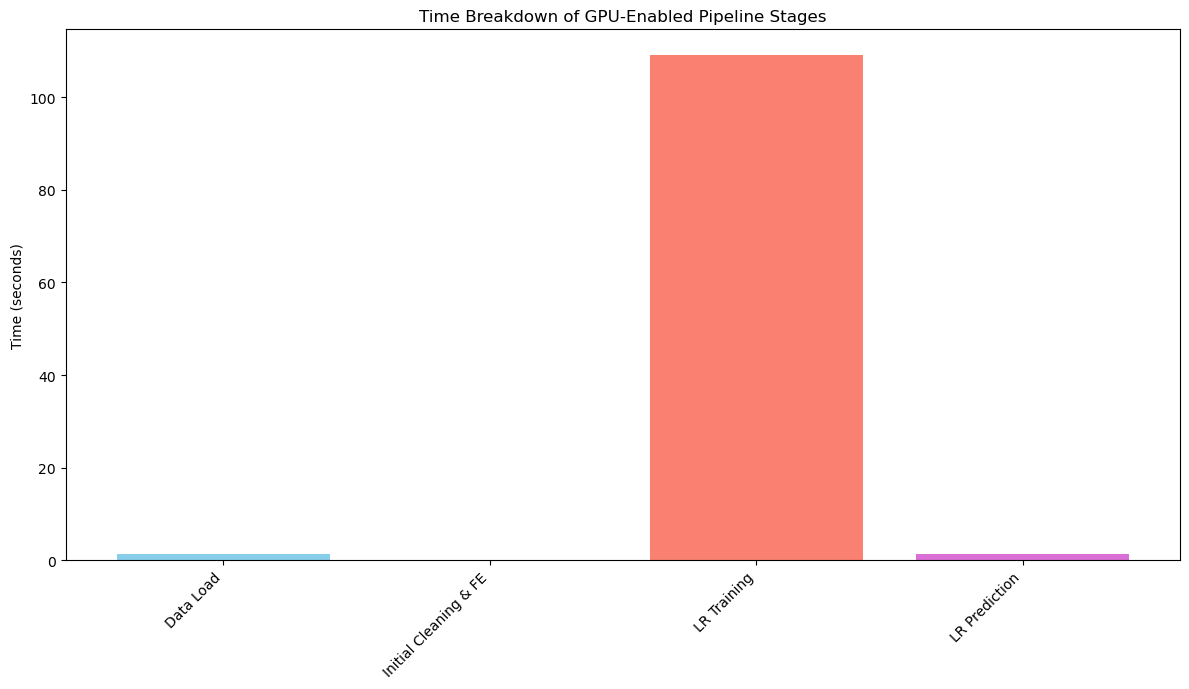

25/08/08 14:09:23 WARN GpuOverrides: 
!Exec <ProjectExec> cannot run on GPU because unsupported data types in input: org.apache.spark.ml.linalg.VectorUDT@3bfc3ba7 [features#9278]
  @Expression <AttributeReference> label#5576 could run on GPU
  @Expression <Alias> pythonUDF0#11130.prediction AS prediction#9755 could run on GPU
    @Expression <GetStructField> pythonUDF0#11130.prediction could run on GPU
      @Expression <AttributeReference> pythonUDF0#11130 could run on GPU
  !Exec <ArrowEvalPythonExec> cannot run even partially on the GPU because unsupported data types in input: org.apache.spark.ml.linalg.VectorUDT@3bfc3ba7 [features#9278]; unsupported data types in output: org.apache.spark.ml.linalg.VectorUDT@3bfc3ba7 [features#9278]; not all expressions can be replaced
    @Expression <PythonUDF> predict_udf(struct(vector_type_c3BhcmstcmFwaWRzLW1sCg==, unwrap_udt(features#9278).type, vector_size_c3BhcmstcmFwaWRzLW1sCg==, unwrap_udt(features#9278).size, vector_indices_c3BhcmstcmFwaWR

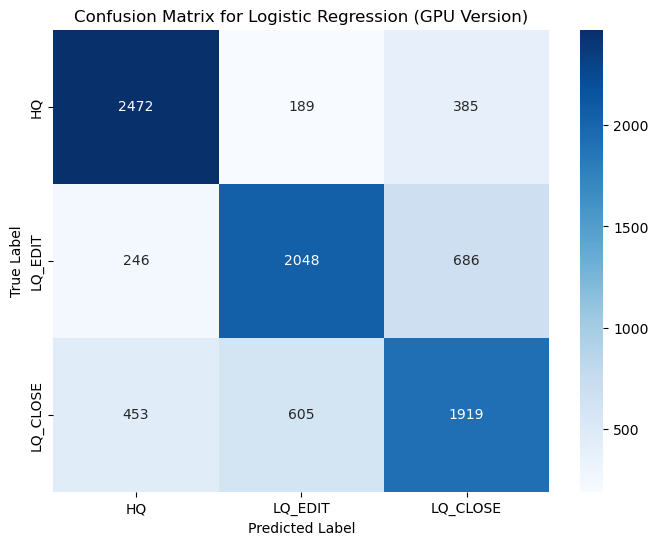

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np 

try:
    times_gpu = {
        "Data Load": load_time,
        "Initial Cleaning & FE": clean_feature_time,
        "LR Training": lr_train_time,
        "LR Prediction": lr_predict_time
    }

    labels_gpu = list(times_gpu.keys())
    values_gpu = list(times_gpu.values())

    plt.figure(figsize=(12, 7))
    plt.bar(labels_gpu, values_gpu, color=['skyblue', 'lightgreen', 'salmon', 'orchid'])
    plt.ylabel("Time (seconds)")
    plt.title("Time Breakdown of GPU-Enabled Pipeline Stages")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig("gpu_pipeline_time_breakdown_srai.png")
    plt.show()

except NameError:
    print("Time tracking variables not defined, skipping GPU time breakdown plot.")
except Exception as e:
    print(f"Error generating GPU time breakdown plot: {e}")
    traceback.print_exc()

try:
    predictions_pd = lr_predictions.select("label", "prediction").toPandas()
    cm = confusion_matrix(predictions_pd["label"], predictions_pd["prediction"])
    class_labels = ["HQ", "LQ_EDIT", "LQ_CLOSE"]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix for Logistic Regression (GPU Version)")
    plt.savefig("gpu_confusion_matrix_lr_srai.png")
    plt.show()

except Exception as e:
    print(f"Error generating GPU confusion matrix plot: {e}")
    traceback.print_exc()


finally:
    try:
        if 'spark' in locals() and spark is not None:
            spark.stop()
    except Exception as e:
        print(f"Error stopping Spark session: {e}")
        traceback.print_exc()